<a href="https://colab.research.google.com/github/AIWintermuteAI/Seeed_Python_MachineLearning/blob/main/jupyter_notebooks/aXeleRate_lung_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Segmentation model Training and Inference

In this notebook we will use axelerate Keras-based framework for AI on the edge to quickly setup model training and then after training session is completed convert it to .tflite format for optimized inference with Raspberry Pi 4 CM inside of reTerminal. Of course, the model will work just as well with original Raspberry Pi or other supported hardware.

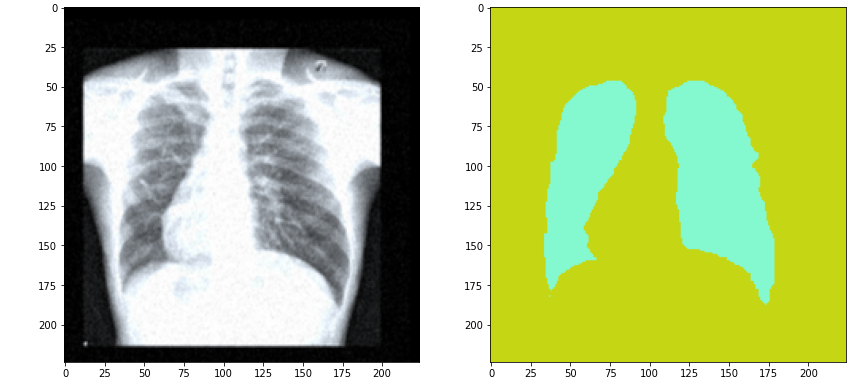

First, let's take care of some administrative details. 

1) Before we do anything, make sure you have choosen GPU as Runtime type (in Runtime - > Change Runtime type).

2) We need to mount Google Drive for saving our model checkpoints and final converted model(s). Press on Mount Google Drive button in Files tab on your left. 

In the next cell we clone axelerate Github repository and import it. 

**It is possible to use pip install or python setup.py install, but in that case you will need to restart the enironment.** Since I'm trying to make the process as streamlined as possibile I'm using sys.path.append for import.

In [ ]:
#we need imgaug 0.4 for image augmentations to work properly, see https://stackoverflow.com/questions/62580797/in-colab-doing-image-data-augmentation-with-imgaug-is-not-working-as-intended
!pip uninstall -y imgaug && pip uninstall -y albumentations && pip install imgaug==0.4
!git clone https://github.com/AIWintermuteAI/aXeleRate.git
import sys
sys.path.append('/content/aXeleRate')
from axelerate import setup_training, setup_inference

At this step you typically need to get the dataset. You can use !wget command to download it from somewhere on the Internet or !cp to copy from My Drive as in this example
```
!cp -r /content/drive/'My Drive'/pascal_20_segmentation.zip .
!unzip --qq pascal_20_segmentation.zip
```
For this notebook we'll download the dataset I shared on Google Drive - it is digital image database for Tuberculosis, created by the National Library of Medicine, Maryland, USA in collaboration with Shenzhen No.3 People’s Hospital, Guangdong Medical College, Shenzhen, China. It contains:
- 336 cases with manifestation of tuberculosis, and 
- 326 normal cases.

The processed version of dataset I repackaged contains 688 training images and segmentation masks and 16 validation images and segmentation masks. The images and masks are resized to 512x512 pixels.

For semantic segmentation the dataset consists of RGB images and segmentation masks. 
A few things to keep in mind:

- The filenames of the annotation images should be same as the filenames of the RGB images.

- The dimensions of the annotation image for the corresponding RGB image should be same.

- For each pixel in the RGB image, the class label of that pixel in the annotation image would be the value of the annotation image pixel.

Let's visualize our semantic segmentation test dataset and see what that means in practice.


In [ ]:
%matplotlib inline
!gdown https://drive.google.com/uc?id=1yefDl16blIpHMln5_ylgfk1-k1hhx0hr
!unzip --qq -d lung_segmentation lung_segmentation.zip

from axelerate.networks.common_utils.augment import visualize_segmentation_dataset

visualize_segmentation_dataset(images_path = 'lung_segmentation/imgs_validation', segs_path = 'lung_segmentation/anns_validation', num_imgs = 10, img_size=224, augment=True, n_classes=2)

Next step is defining a config dictionary. Most lines are self-explanatory.

Type is model frontend - Classifier, Detector or Segnet

Architecture is model backend (feature extractor) 

- Full Yolo
- Tiny Yolo
- MobileNet1_0
- MobileNet7_5 
- MobileNet5_0 
- MobileNet2_5 
- SqueezeNet
- NASNetMobile
- ResNet50
- DenseNet121

For converter type you can choose the following:

'k210', 'tflite_fullint', 'tflite_dynamic', 'edgetpu', 'openvino', 'onnx'

In [ ]:
config = {
            "model" : {
                "type":                 "SegNet",
                "architecture":         "MobileNet5_0",
                "input_size":           224,
                "n_classes" : 		      2
            },
            "weights" : {
            "full":   				"",
            "backend":   		    "imagenet"
        },
            "train" : {
                "actual_epoch":         30,
                "train_image_folder":   "lung_segmentation/imgs",
                "train_annot_folder":   "lung_segmentation/anns",
                "train_times":          1,
                "valid_image_folder":   "lung_segmentation/imgs_validation",
                "valid_annot_folder":   "lung_segmentation/anns_validation",
                "valid_times":          1,
                "valid_metric":         "val_loss",
                "batch_size":           16,
                "learning_rate":        1e-3,
                "saved_folder":   		F"/content/drive/MyDrive/projects/lung_segmentation",
                "first_trainable_layer": "",
                "ignore_zero_class":    False,
                "augumentation":				True
            },
            "converter" : {
                "type":   				['tflite_fullint']
            }
        }

Let's check what GPU we have been assigned in this Colab session, if any.

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Also, let's open Tensorboard, where we will be able to watch model training progress in real time. Training and validation logs also will be saved in project folder.
Since there are no logs before we start the training, tensorboard will be empty. Refresh it after first epoch.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs
!sleep 10

Finally we start the training by passing config dictionary we have defined earlier to setup_training function. The function will start the training with Checkpoint, Cosine Annealing LR Schedule with Warm-up and Early Stopping callbacks. If you have specified the converter type in the config, after the training has stopped the script will convert the best model into the format you have specified in config and save it to the project folder.

In [ ]:
from keras import backend as K 
K.clear_session()
model_path = setup_training(config_dict=config)

After training it is good to check the actual perfomance of your model by doing inference on your validation dataset and visualizing results. This is exactly what next block does. Our model used pre-trained weights and since we set learning rate to 0, we are just observing the perfomance of the model that was trained before.

In [ ]:
%matplotlib inline
from keras import backend as K 
K.clear_session()
setup_inference(config, model_path)

If you need to convert trained model to other formats, for example for inference with OpenCV AI Kit or Raspberry Pi(with quantized tflite model), you can do it with following commands. Specify the converter type, backend and folder with calbiration images(normally your validation image folder).

In [ ]:
from axelerate.networks.common_utils.convert import Converter
converter = Converter('edgetpu', 'MobileNet5_0', 'human_segmentation/imgs_validation')
converter.convert_model(model_path)

Good luck and happy training! Have a look at these articles, that would allow you to get the most of Google Colab or connect to local runtime if there are no GPUs available;

https://medium.com/@oribarel/getting-the-most-out-of-your-google-colab-2b0585f82403

https://research.google.com/colaboratory/local-runtimes.html